# Expana -- assignment interview

## Create a presentation where you describe the characteristics of this time series and explain how you expect it to evolve until the end of 2023.

### 1. Loading the libraries and the data

In [55]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA



color_pale = sns.color_palette()
plt.style.use('seaborn-v0_8')

<Axes: title={'center': 'Exapana time series'}, xlabel='Date'>

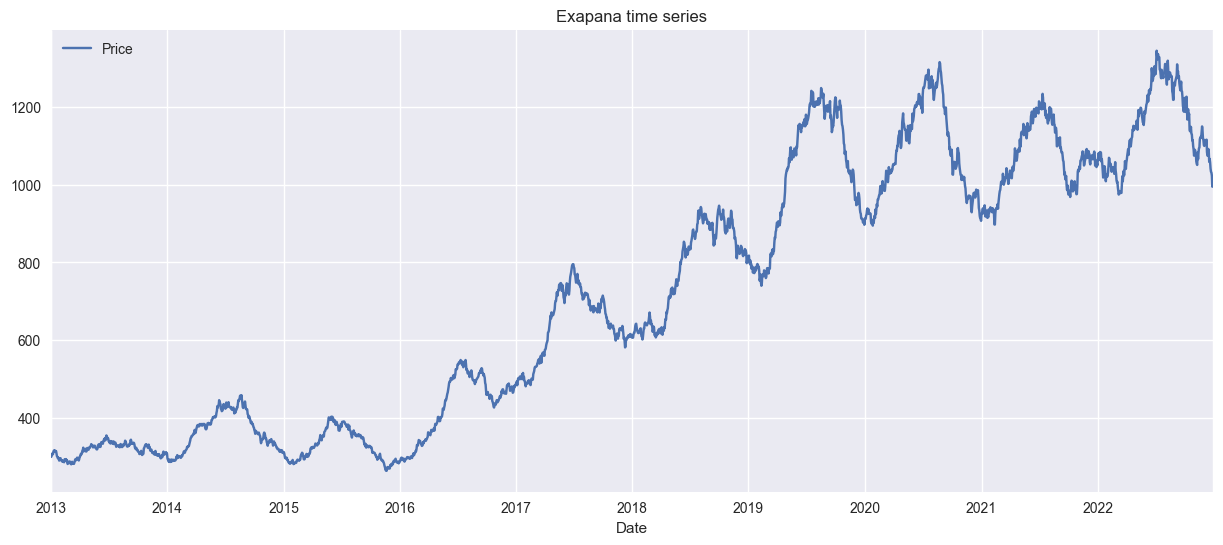

In [56]:
df = pd.read_excel("quantitative_analyst_case_Feb_2025.xlsx")
# date format: timstamp YYYY-mm-dd
df = df.set_index("Date")
df.plot(figsize=(15, 6), color = color_pale[0], title= "Exapana time series")

In [57]:
#checking the starting date and end date
df.index.min(), df.index.max()

(Timestamp('2012-12-31 00:00:00'), Timestamp('2022-12-30 00:00:00'))

### 1.1 Time series components
We know that time series is a combination of (maunly) three components:
- Trend: overall development of the series. It can consistently increase or decrease over time or a combination of both
- Seasonality: any seasonal pattern during the series
- Residuals whih have been always thought as statistical noise (random irregularity present in real-life data)

In [58]:
df = df.resample(rule = 'd').mean().ffill().asfreq('D')

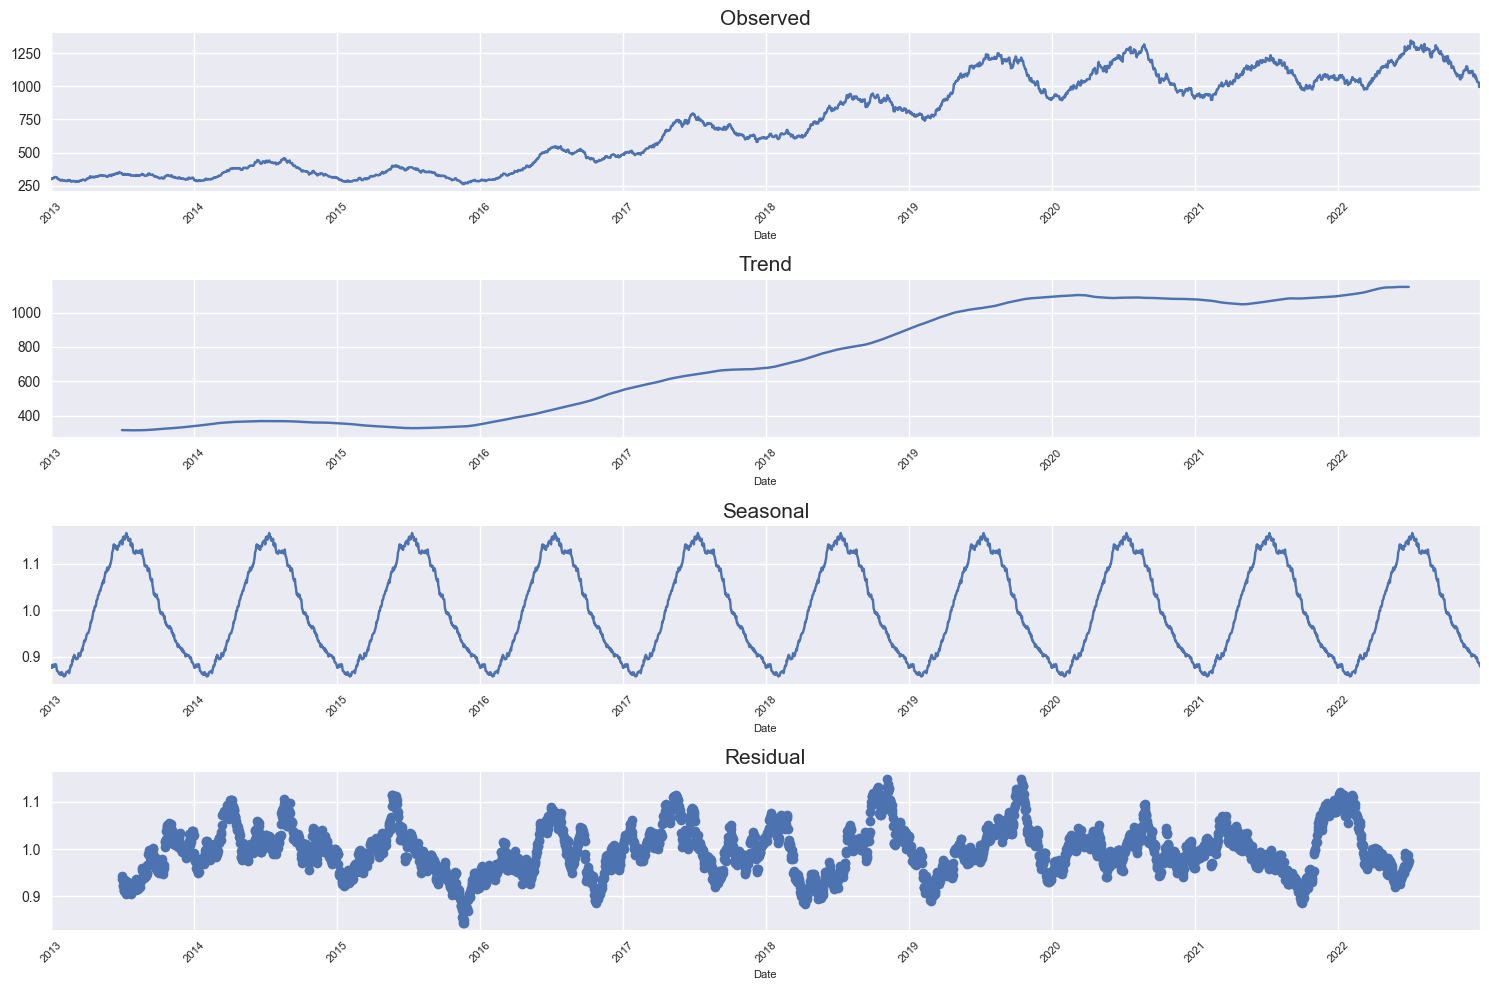

In [59]:
#no data for weekends etc. price from last non-null date is used to fill the data
decomposition_plot_multi = seasonal_decompose(df["Price"], model='multiplicative', period=365)

fig, axes = plt.subplots(4, 1, figsize=(15, 10))  # Adjust figsize for width and height

decomposition_plot_multi.observed.plot(ax=axes[0])
axes[0].set_title('Observed', fontsize = 15)
axes[0].set_xlabel("Date", fontsize = 8)
axes[0].tick_params(axis='x', rotation=45, labelsize=8) # Rotate x-axis ticks if needed

decomposition_plot_multi.trend.plot(ax=axes[1])
axes[1].set_title('Trend', fontsize = 15)
axes[1].set_xlabel("Date", fontsize = 8)
axes[1].tick_params(axis='x', rotation=45, labelsize=8) # Rotate x-axis ticks if needed

decomposition_plot_multi.seasonal.plot(ax=axes[2])
axes[2].set_title('Seasonal', fontsize = 15)
axes[2].set_xlabel("Date", fontsize = 8)
axes[2].tick_params(axis='x', rotation=45, labelsize=8) # Rotate x-axis ticks if needed

decomposition_plot_multi.resid.plot(ax=axes[3], linestyle='None', marker = 'o')
axes[3].set_title('Residual', fontsize = 15)
axes[3].set_xlabel("Date", fontsize = 8)
axes[3].tick_params(axis='x', rotation=45, labelsize=8) # Rotate x-axis ticks if needed


plt.tight_layout() # Important: Adjusts subplot params for a tight layout
plt.show()

In [60]:
# rolling_variance = df['Price'].rolling(window=15).var()

# # Plotting the rolling variance
# plt.figure(figsize=(15, 5))
# plt.plot(rolling_variance, label='Rolling Variance (12-period)', color=color_pale[0])
# plt.title('Rolling Variance of the Time Series', fontsize = 15)
# plt.xlabel('Time')
# plt.ylabel('Variance')
# plt.legend()
# plt.show()

### 1.2 Stionarize time series (Differencinig)

Key Indicators of Stationarity:
- Constant Mean: The data seems to fluctuate around a roughly constant mean (around 0). There's no obvious upward or downward trend in the center of the fluctuations over time.
- On the other side, the variance does not seem to be constant over time, with increasing fluctuations starting from year 2017

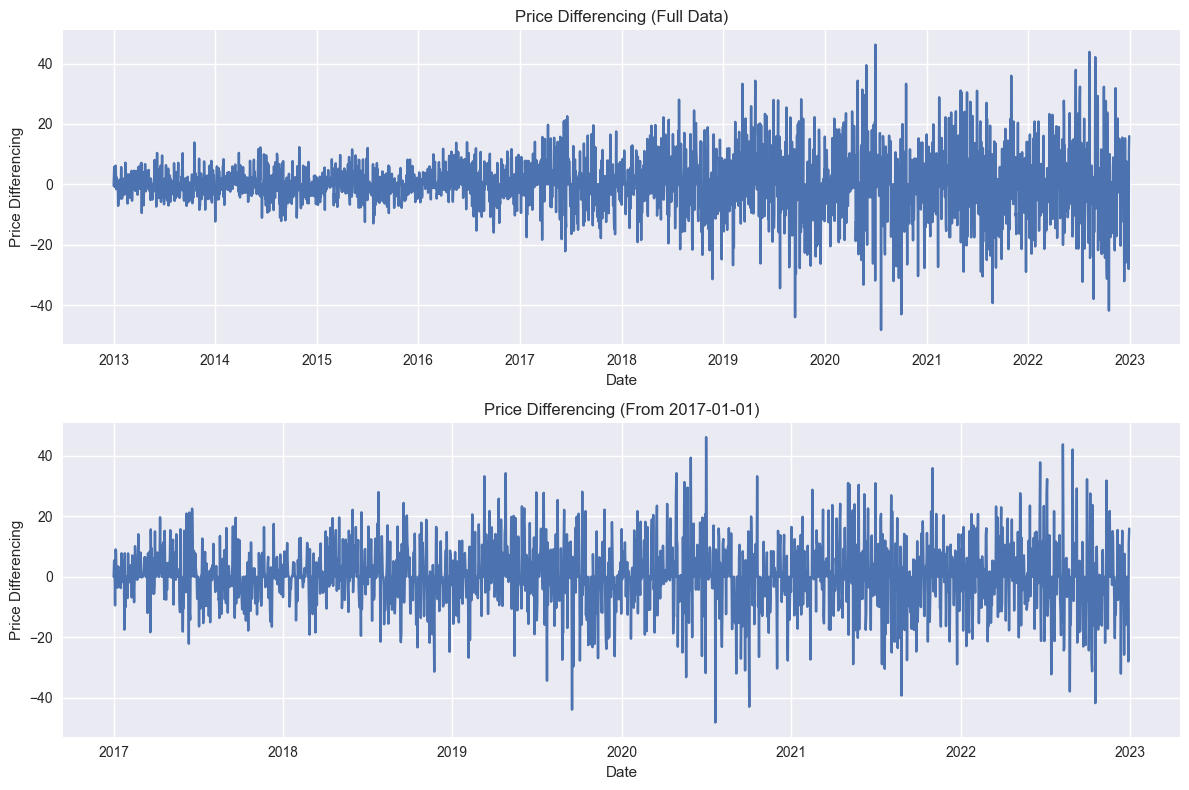

In [7]:
df_copy = df.copy()
df_copy["Price_differencing"] = df_copy["Price"].diff()
fig, axes = plt.subplots(2, 1, figsize=(12, 8))  # 2 rows, 1 column

# Plot 1: Full data
sns.lineplot(data=df_copy, x=df_copy.index, y="Price_differencing", ax=axes[0])
axes[0].set_title("Price Differencing (Full Data)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Price Differencing")

# Plot 2: Data from 2017-01-01 onwards
subset = df_copy[df_copy.index >= "2017-01-01"]  # Create the subset efficiently
sns.lineplot(data=subset, x=subset.index, y="Price_differencing", ax=axes[1])  # Use subset's index
axes[1].set_title("Price Differencing (From 2017-01-01)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Price Differencing")

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Show the plot
plt.show()

To formally check whether the series in stationaty, we can consider the Augmented Dickey-Fuller Test (ADF). Given the p-value a very small number close to zero and therefore smaller than the significance level, we can reject the null hypothesis stating that the series is stationary.

In [8]:
df_copy = df_copy.dropna()
result = adfuller(df_copy['Price_differencing'])  # Drop NaN values if differencing created any

# Print the results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

# Interpretation
if result[1] < 0.05:
    print("The series is stationary (reject H0)")
else:
    print("The series is NOT stationary (fail to reject H0)")

ADF Statistic: -10.572622559812006
p-value: 7.239452640018001e-19
Critical Values: {'1%': np.float64(-3.432152735611742), '5%': np.float64(-2.8623365480522964), '10%': np.float64(-2.567194014828981)}
The series is stationary (reject H0)


However, as seen above we detected an increasing level of heteroskedasticity in the right part of the chart, hence towards the en ot the series. By lokking at the plot below we can observe the following:
- The red line (rolling standard deviation) shows a gradual increase, especially from 2019 onward.
- The fluctuations in the blue series (price differencing) also become more extreme over time.
- This suggests that the variance is not constant, which is a sign of heteroskedasticity.

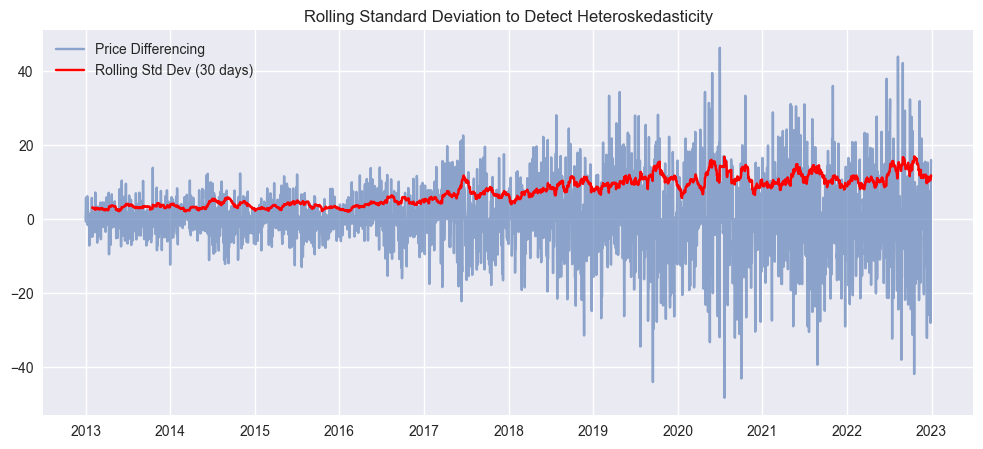

In [9]:
rolling_std = df_copy['Price_differencing'].rolling(window=30).std()

# Plot the original series and rolling std deviation
plt.figure(figsize=(12, 5))
plt.plot(df_copy.index, df_copy['Price_differencing'], label="Price Differencing", alpha=0.6)
plt.plot(df_copy.index, rolling_std, label="Rolling Std Dev (30 days)", color='red')
plt.legend()
plt.title("Rolling Standard Deviation to Detect Heteroskedasticity")
plt.show()

Therefore to stabilize the variance, I'll apply the log transformation and plot the data

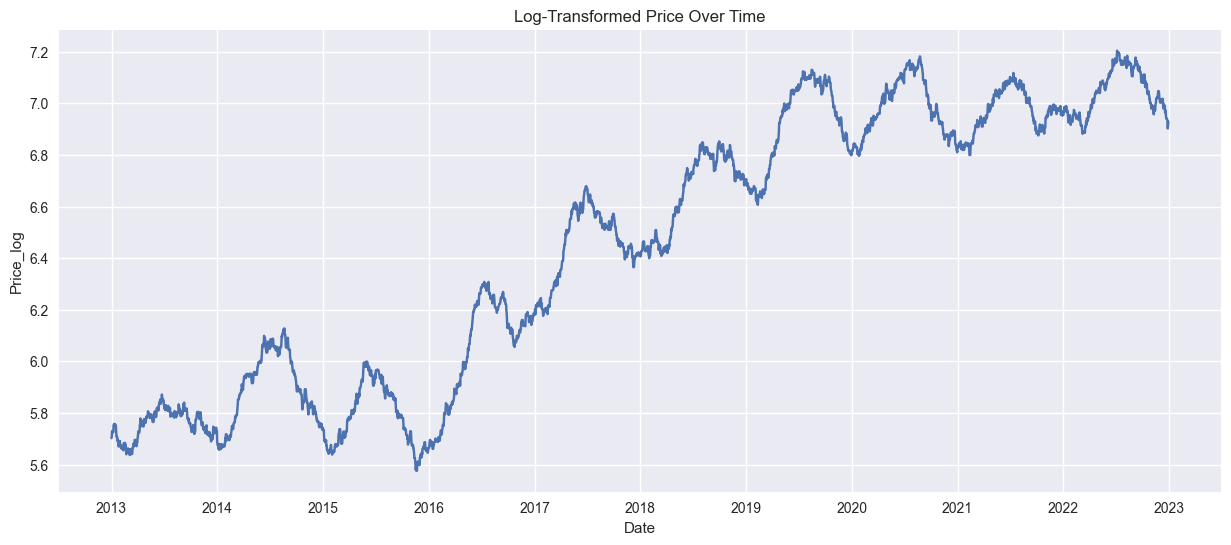

In [10]:
df_copy["Price_log"] = np.log(df_copy["Price"])

# Plot the log-transformed prices
plt.figure(figsize=(15, 6))  # Set figure size here
sns.lineplot(data=df_copy, x=df_copy.index, y="Price_log")
plt.title("Log-Transformed Price Over Time")
plt.show()

Is the time series staionary now?

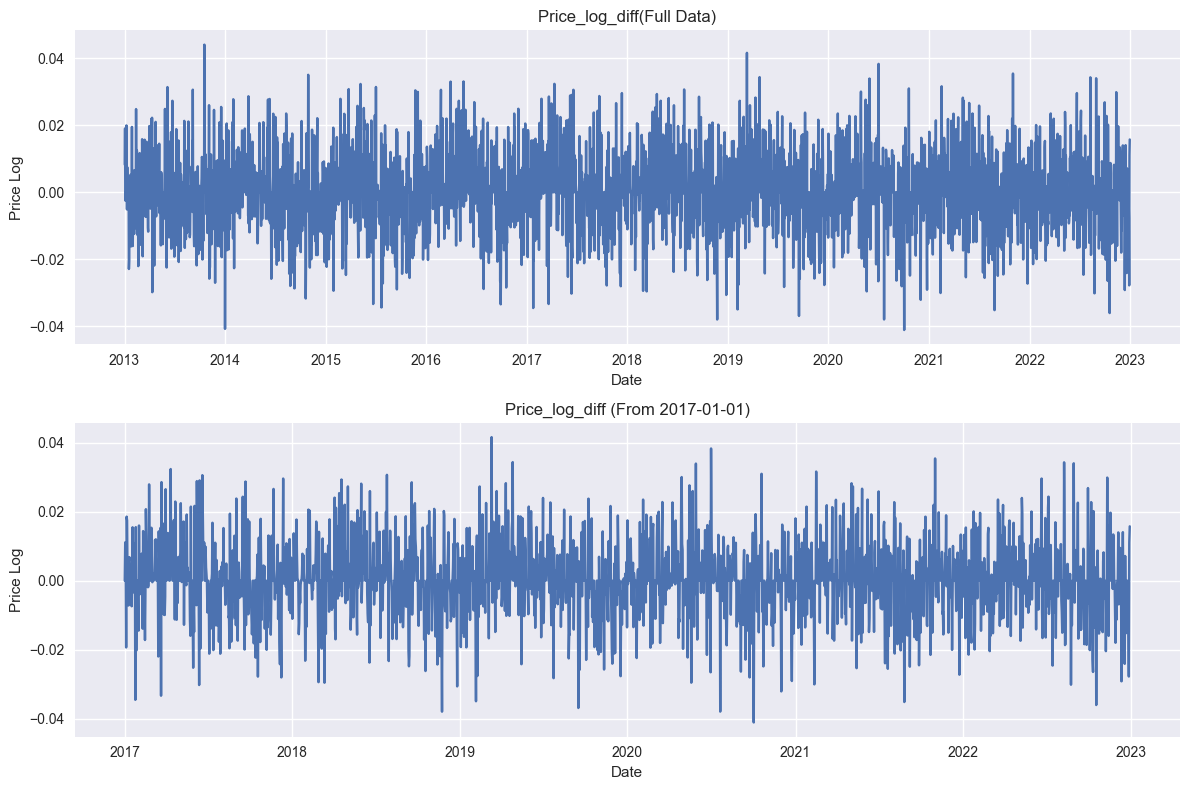

In [11]:
df_copy["Price_log_diff"] = df_copy["Price_log"].diff()
fig, axes = plt.subplots(2, 1, figsize=(12, 8))  # 2 rows, 1 column

# Plot 1: Full data
sns.lineplot(data=df_copy, x=df_copy.index, y="Price_log_diff", ax=axes[0])
axes[0].set_title("Price_log_diff(Full Data)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Price Log")

# Plot 2: Data from 2017-01-01 onwards
subset = df_copy[df_copy.index >= "2017-01-01"]  # Create the subset efficiently
sns.lineplot(data=subset, x=subset.index, y="Price_log_diff", ax=axes[1])  # Use subset's index
axes[1].set_title("Price_log_diff (From 2017-01-01)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Price Log")

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Show the plot
plt.show()

Now after applying differencing on the log transformed data, we can safely assess that (from a visual point of view) the series seems to be stationary as the variance does no fluctuate over time. To validate our hypothesis we can run the ADF one again and check the statistical significance

In [12]:
df_copy

,Price,Price_differencing,Price_log,Price_log_diff
Date,,,,
2013-01-01,299.553248,-0.446752,5.702292,NaN
2013-01-02,302.043389,2.490141,5.710571,0.008278
2013-01-03,307.849084,5.805694,5.729610,0.019039
2013-01-04,307.091766,-0.757317,5.727147,-0.002463
2013-01-05,307.091766,0.000000,5.727147,0.000000
...,...,...,...,...
2022-12-26,1030.524458,-2.576881,6.937823,-0.002497
2022-12-27,1022.667013,-7.857445,6.930169,-0.007654
2022-12-28,994.676194,-27.990819,6.902417,-0.027752


In [13]:
df_copy = df_copy.dropna()
result = adfuller(df_copy['Price_log_diff'])  

# Print the results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

# Interpretation
if result[1] < 0.05:
    print("The series is stationary (reject H0)")
else:
    print("The series is NOT stationary (fail to reject H0)")

ADF Statistic: -12.843969348237186
p-value: 5.5306017649273614e-24
Critical Values: {'1%': np.float64(-3.432150254165979), '5%': np.float64(-2.8623354519441797), '10%': np.float64(-2.567193431297053)}
The series is stationary (reject H0)


ACF
- Strong Positive Autocorrelation at Lag 1: The most prominent feature is the very high autocorrelation at lag 1. This suggests a strong relationship between consecutive data points. In simpler terms, if the price was high in the previous period, it's likely to be high in the current period as well. This is a common characteristic of many time series, especially financial ones.

<Figure size 2000x1000 with 0 Axes>

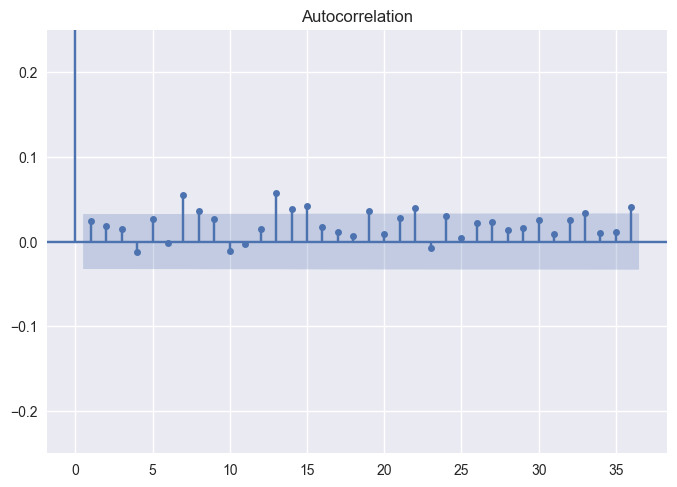

In [14]:
# # ACF plot
plt.figure(figsize=(20, 10))

plot_acf(df_copy['Price_log_diff'])#, lags= np.arange(100)) #Price_log_diff

plt.ylim(-0.25, 0.25)
plt.show()

PACF:
- Significant Spike at Lag 1: The most prominent feature is the large, statistically significant spike at lag 1. This indicates a strong direct relationship between the current time point and the immediately preceding time point.  It suggests that the value at time t is highly correlated with the value at time t-1, after accounting for the influence of other lags.
- Insignificant Autocorrelations Beyond Lag 2:  For lags greater than 2, the partial autocorrelations are very close to zero and well within the significance bounds. This indicates that there's no significant direct relationship between the current time point and those earlier time points, once the influence of lags 1 and (possibly) 2 are accounted for.

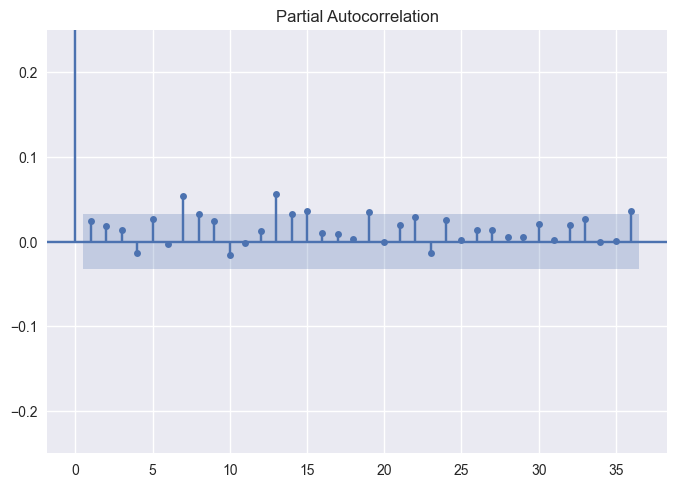

In [15]:
plot_pacf(df_copy['Price_log_diff'])
# # Set the y-axis limits to zoom in between -0.25 and 0.25
plt.ylim(-0.25, 0.25)

plt.show()

In [16]:
# Split the data into train and test
train_size = int(len(df_copy) * 0.8)
train, test = df_copy[0:train_size], df_copy[train_size:len(df_copy)]

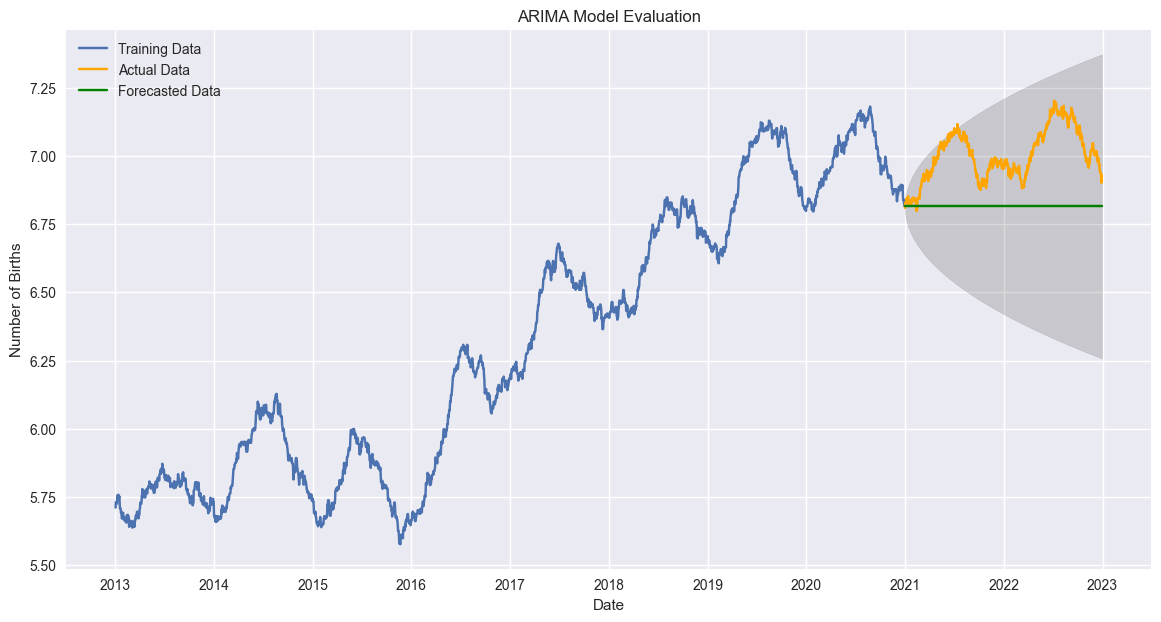

RMSE: 0.21084126407991138


In [17]:
model = ARIMA(train['Price_log'], order=(0, 1, 0))
model_fit = model.fit()


# Forecast on the test dataset
test_forecast = model_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

# Calculate the mean squared error
mse = mean_squared_error(test['Price_log'], test_forecast_series)
rmse = np.sqrt(mse)

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(14,7))
plt.plot(train['Price_log'], label='Training Data')
plt.plot(test['Price_log'], label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test.index, 
                 test_forecast.conf_int().iloc[:, 0], 
                 test_forecast.conf_int().iloc[:, 1], 
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.show()

print('RMSE:', rmse)

### 2. Applaying feature engineering

In [61]:
def create_features(df):   
    """
    Create additional features from the date index
    """
    df["dayofweek"] = df.index.day_of_week.astype(int)
    df["dayofyear"] = df.index.day_of_year.astype(int)
    df["dayofmonth"] = df.index.day
    df["month"] = df.index.month.astype(int)
    df["quarter"] = df.index.quarter.astype(int)
    df["year"] = df.index.year.astype(int)
    df["weekofyear"] = df.index.isocalendar().week

    return df

df = create_features(df)

In [62]:
df

,Price,dayofweek,dayofyear,dayofmonth,month,quarter,year,weekofyear
Date,,,,,,,,
2012-12-31,300.000000,0,366,31,12,4,2012,1
2013-01-01,299.553248,1,1,1,1,1,2013,1
2013-01-02,302.043389,2,2,2,1,1,2013,1
2013-01-03,307.849084,3,3,3,1,1,2013,1
2013-01-04,307.091766,4,4,4,1,1,2013,1
...,...,...,...,...,...,...,...,...
2022-12-26,1030.524458,0,360,26,12,4,2022,52
2022-12-27,1022.667013,1,361,27,12,4,2022,52
2022-12-28,994.676194,2,362,28,12,4,2022,52


### 2.1 Creating Lag features
Identifying the target variable x days in the past

In [63]:
def creating_lags(df, n_lags=4, start=5):
    """
    Create n lagged features with a step size that is double the starting point.
    
    Parameters:
        df (pd.DataFrame): The original DataFrame with a datetime index and a 'Price' column.
        n_lags (int): Number of lagged features to create.
        start (int): The starting lag (e.g., 30 days).
    
    Returns:
        pd.DataFrame: The DataFrame with added lagged features.
        list: List of created lag column names.
    """
    # Set step to be twice the start
    step = start * 2

    # Convert 'Price' column to dictionary for fast lookup
    price_target = df["Price"].to_dict()
    
    # Create lagged features
    for i in range(n_lags):
        lag = start + (i * step)
        df[f"lag_{lag}"] = (df.index - pd.Timedelta(days=lag)).map(price_target)

    # Fill NaN values with 0
    df.fillna(0, inplace=True)

    # Extract the list of created lag features
    lags = df.columns[-n_lags:].to_list()
    
    return df, lags


df, lags = creating_lags(df)
df

,Price,dayofweek,dayofyear,dayofmonth,month,quarter,year,weekofyear,lag_5,lag_15,lag_25,lag_35
Date,,,,,,,,,,,,
2012-12-31,300.000000,0,366,31,12,4,2012,1,0.000000,0.000000,0.000000,0.000000
2013-01-01,299.553248,1,1,1,1,1,2013,1,0.000000,0.000000,0.000000,0.000000
2013-01-02,302.043389,2,2,2,1,1,2013,1,0.000000,0.000000,0.000000,0.000000
2013-01-03,307.849084,3,3,3,1,1,2013,1,0.000000,0.000000,0.000000,0.000000
2013-01-04,307.091766,4,4,4,1,1,2013,1,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,1030.524458,0,360,26,12,4,2022,52,1057.390125,1115.661244,1101.750808,1120.258993
2022-12-27,1022.667013,1,361,27,12,4,2022,52,1041.444074,1083.613398,1099.449271,1123.664120
2022-12-28,994.676194,2,362,28,12,4,2022,52,1033.101338,1074.562481,1099.449271,1120.990001


### 3. Visualize feature/target relationship

C:\Users\matte\AppData\Local\Temp\ipykernel_15828\327078365.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\matte\AppData\Local\Temp\ipykernel_15828\327078365.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\matte\AppData\Local\Temp\ipykernel_15828\327078365.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


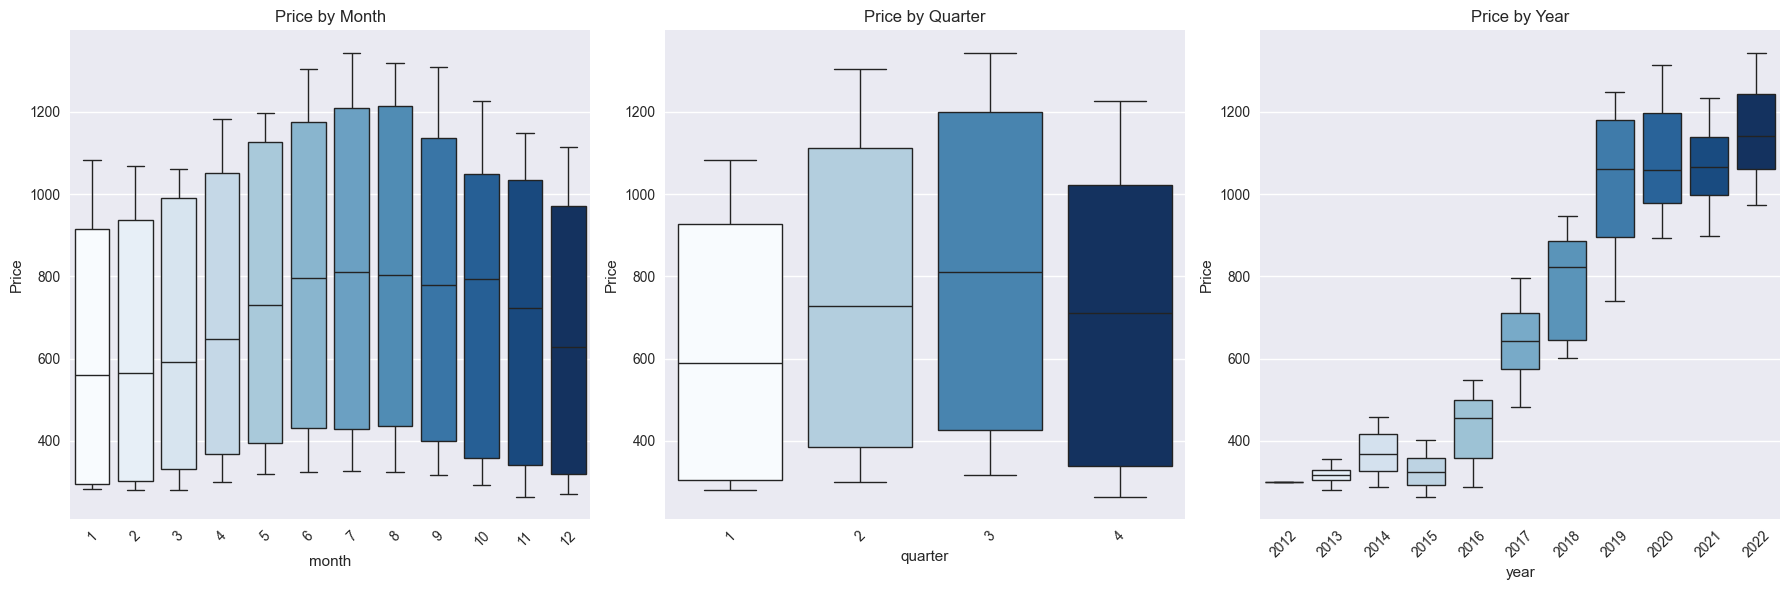

In [64]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Boxplot by Month ---
sns.boxplot(data=df, x="month", y="Price", ax=axes[0], hue = "month", legend= False, palette="Blues")
axes[0].set_title("Price by Month")

# Boxplot by Quarter ---
sns.boxplot(data=df, x="quarter", y="Price", ax=axes[1], hue = "quarter", legend= False, palette="Blues")
axes[1].set_title("Price by Quarter")

# Boxplot by Year ---
sns.boxplot(data=df, x="year", y="Price", ax=axes[2], hue = "year", legend= False, palette="Blues")
axes[2].set_title("Price by Year")

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### 4. Train test split

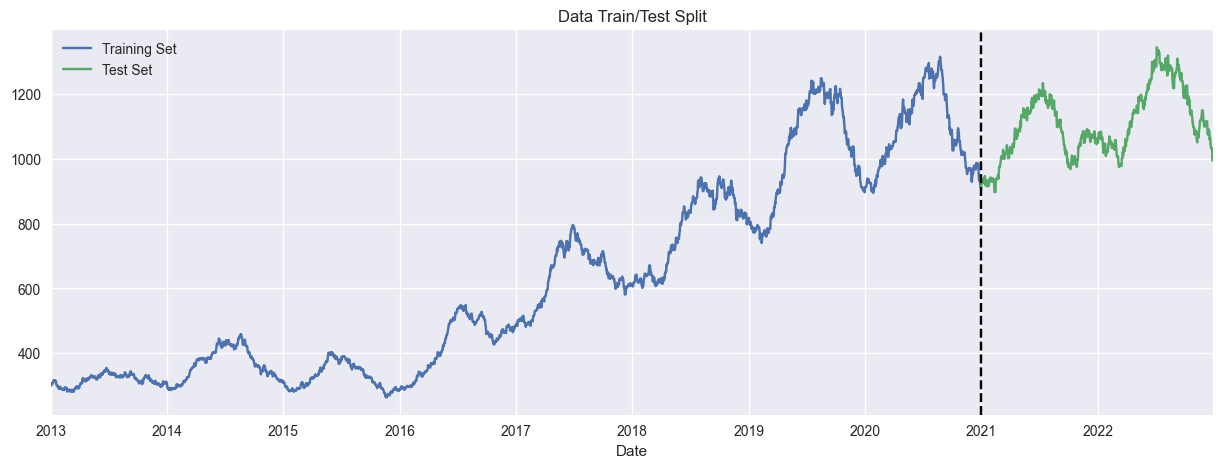

Length of the training set 2921
Length of the test set 731


In [65]:
#get the date to split between training and test set
df_copy = df.copy()
df_copy = df_copy.reset_index()
split_index = int(len(df_copy) * 0.8)

date_index = df_copy.iloc[split_index]["Date"]
df_copy = df_copy.set_index("Date")


# Split the data based on the index
train = df_copy.iloc[:split_index]
test = df_copy.iloc[split_index:]

# Create a plot
fig, ax = plt.subplots(figsize=(15, 5))

# Plot both training and testing data (assume you want to plot the entire dataframe)
train["Price"].plot(ax=ax, label='Training Set')
test["Price"].plot(ax=ax, label='Test Set')

# Add vertical line at the split point
ax.axvline(pd.to_datetime(df.index[df.index==date_index]), color='black', ls='--')

# Add legend and title
ax.legend(['Training Set', 'Test Set'])
ax.set_title('Data Train/Test Split')

# Show the plot
plt.show()

print("Length of the training set", len(train))
print("Length of the test set", len(test))

### 4.1 Training the model with one split

In [66]:
def creating_train_test_sets(df_copy, train, test):    
    features = df_copy.columns.to_list()
    features.remove("Price")
    target = "Price"

    #setting up training
    X_train = train[features]
    y_train = train[target]

    #setting up test
    X_test = test[features]
    y_test = test[target]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = creating_train_test_sets(df_copy, train=train, test=test)

def training_model_and_getting_predictions(X_train, y_train, X_test, y_test):

    """
    Training the model and returning prediciton and model object
    """

    #setting up model
    reg_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',   
                            n_estimators=500,
                            early_stopping_rounds=10,
                            objective='reg:squarederror',
                            max_depth=3,
                            learning_rate=0.1)

    reg_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
    y_pred = reg_model.predict(X_test)
    return y_pred, reg_model

y_pred, model = training_model_and_getting_predictions(X_train, y_train, X_test, y_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
score = np.sqrt(mean_squared_error(y_test, y_pred))
score_2 = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {score}")
print(f"Mean Absolute Percentage Error: {score_2}")

[0]	validation_0-rmse:624.83827	validation_1-rmse:1001.39901


[95]	validation_0-rmse:12.50536	validation_1-rmse:26.78737
Mean Squared Error: 713.4324
Root Mean Squared Error: 26.710154990977706
Mean Absolute Percentage Error: 0.018722048992870163


C:\Users\matte\AppData\Local\Temp\ipykernel_15828\1167674002.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


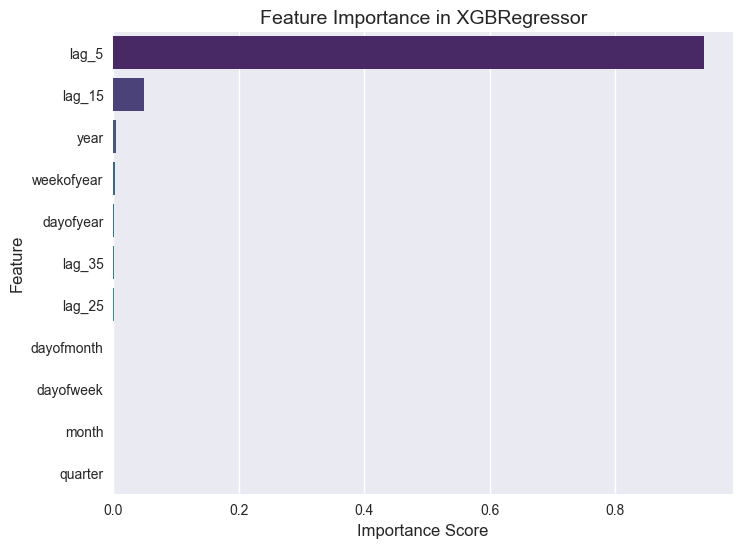

In [67]:
importance_values = model.feature_importances_

# Create a DataFrame to display feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # Feature names
    'Importance': importance_values  # Corresponding importance scores
})

# Sort by importance (descending)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(8, 6))

# Create a horizontal bar plot
sns.barplot(
    x=feature_importance_df["Importance"], 
    y=feature_importance_df["Feature"], 
    palette="viridis"
)

# Add title and labels
plt.title("Feature Importance in XGBRegressor", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=12)

# Show the plot
plt.show()



C:\Users\matte\AppData\Local\Temp\ipykernel_15828\562165104.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["prediction_one_split"] = y_pred


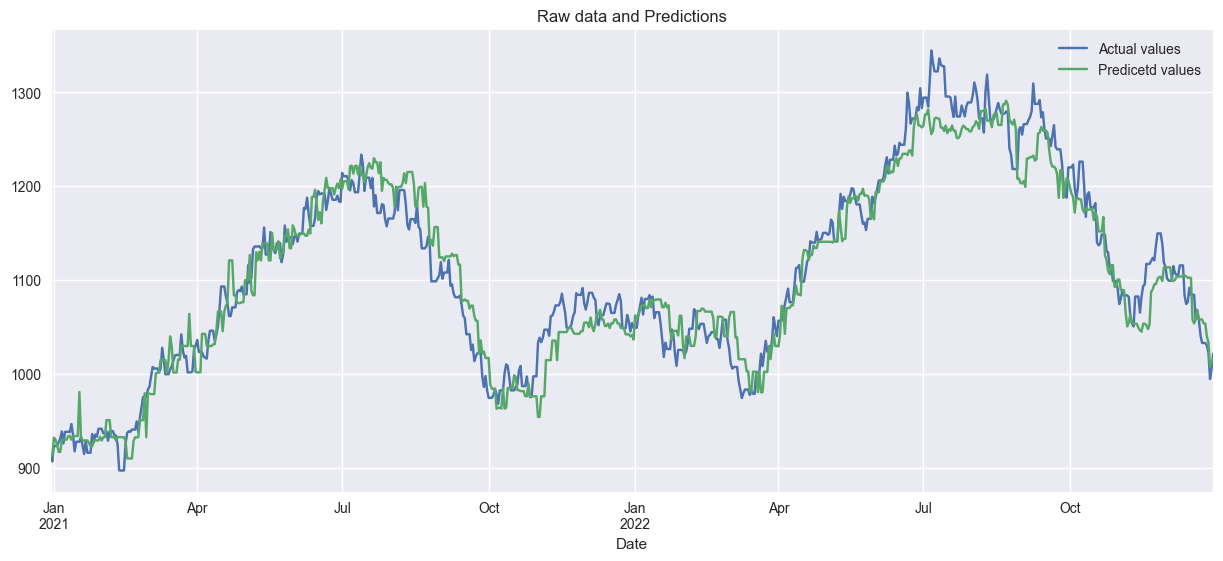

In [68]:
test["prediction_one_split"] = y_pred

ax = test["Price"].plot(figsize=(15, 6))
test["prediction_one_split"].plot(ax=ax)
plt.legend(["Actual values", "Predicetd values"])
plt.title("Raw data and Predictions")
plt.show()

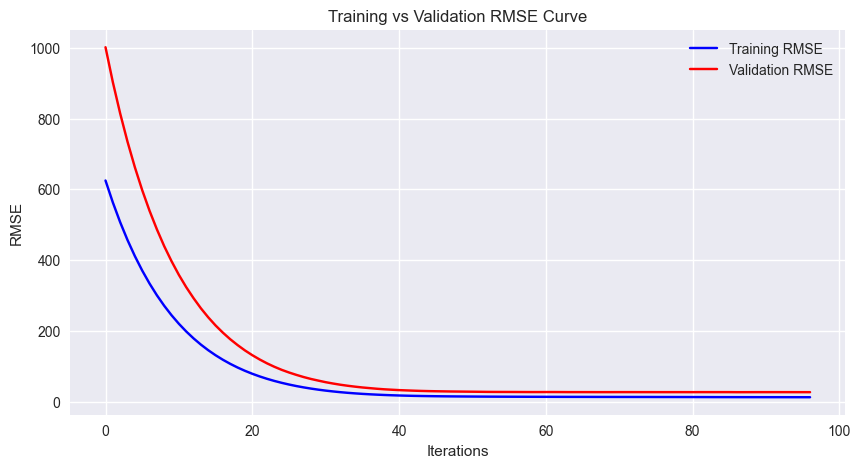

In [69]:
results = model.evals_result_
plt.figure(figsize=(10, 5))
plt.plot(results['validation_0']['rmse'], label="Training RMSE", color='blue')
plt.plot(results['validation_1']['rmse'], label="Validation RMSE", color='red')
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.title("Training vs Validation RMSE Curve")
plt.legend()
plt.show()

### 4.2 Training the model with cross validation split

In [71]:
df_copy

,Price,dayofweek,dayofyear,dayofmonth,month,quarter,year,weekofyear,lag_5,lag_15,lag_25,lag_35
Date,,,,,,,,,,,,
2012-12-31,300.000000,0,366,31,12,4,2012,1,0.000000,0.000000,0.000000,0.000000
2013-01-01,299.553248,1,1,1,1,1,2013,1,0.000000,0.000000,0.000000,0.000000
2013-01-02,302.043389,2,2,2,1,1,2013,1,0.000000,0.000000,0.000000,0.000000
2013-01-03,307.849084,3,3,3,1,1,2013,1,0.000000,0.000000,0.000000,0.000000
2013-01-04,307.091766,4,4,4,1,1,2013,1,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,1030.524458,0,360,26,12,4,2022,52,1057.390125,1115.661244,1101.750808,1120.258993
2022-12-27,1022.667013,1,361,27,12,4,2022,52,1041.444074,1083.613398,1099.449271,1123.664120
2022-12-28,994.676194,2,362,28,12,4,2022,52,1033.101338,1074.562481,1099.449271,1120.990001


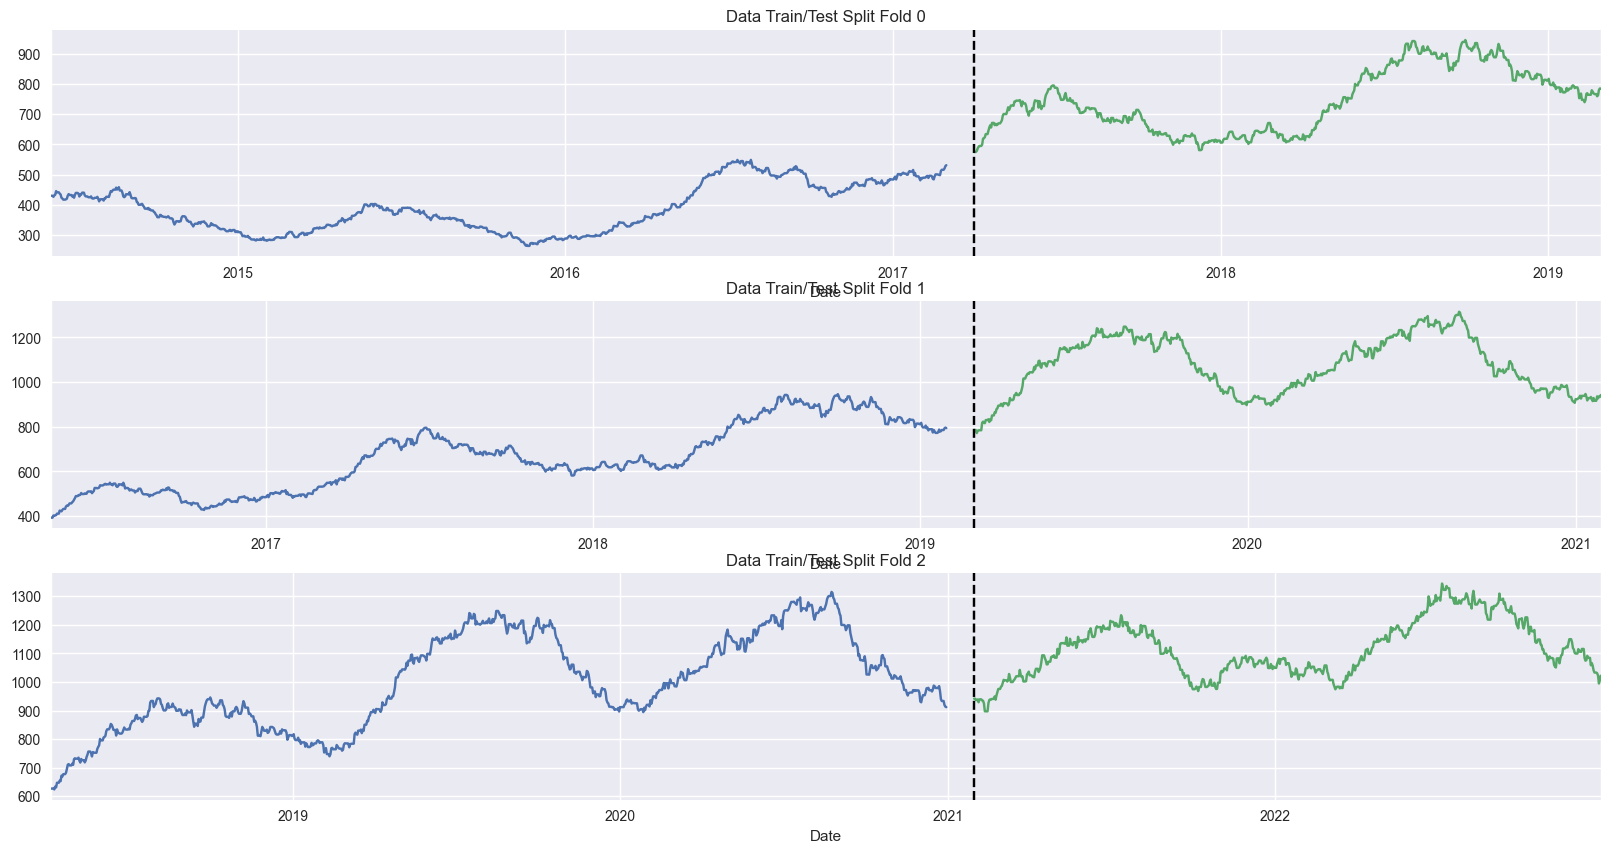

In [72]:
tss = TimeSeriesSplit(n_splits = 3, gap= 30,  max_train_size=1000, test_size=700)

fig, axs = plt.subplots(tss.n_splits, 1, figsize = (20, 10), sharex= False)
fold = 0
for train_idx, val_idx in tss.split(df_copy):
    train = df_copy.iloc[train_idx]
    test = df_copy.iloc[val_idx]
    train['Price'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Price'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [73]:
preds = []
scores = []
score_2 = []
for train_idx, val_idx in tss.split(df_copy):
    train = df_copy.iloc[train_idx]
    test = df_copy.iloc[val_idx]
    
    X_train, X_test, y_train, y_test = creating_train_test_sets(df_copy, train=train, test=test)
    y_pred, model = training_model_and_getting_predictions(X_train, y_train, X_test, y_test)
    
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    score_percentage = mean_absolute_percentage_error(y_test, y_pred)
    score_2.append(score_percentage)
    scores.append(score)

[0]	validation_0-rmse:356.57085	validation_1-rmse:700.00838


[92]	validation_0-rmse:5.53434	validation_1-rmse:247.22771
[0]	validation_0-rmse:608.25213	validation_1-rmse:995.54967
[100]	validation_0-rmse:9.68825	validation_1-rmse:205.23595
[103]	validation_0-rmse:9.62970	validation_1-rmse:205.47340
[0]	validation_0-rmse:909.82321	validation_1-rmse:1008.32173
[77]	validation_0-rmse:14.99425	validation_1-rmse:28.09680


In [74]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')
print("------------------------")
print(f'Score across folds for percentage error{np.mean(score_2):0.4f}')
print(f'Fold scores for percentage error:{score_2}')

Score across folds 159.9658
Fold scores:[np.float64(247.16535687210165), np.float64(204.7248902676244), np.float64(28.00704202544457)]
------------------------
Score across folds for percentage error0.1528
Fold scores for percentage error:[np.float64(0.28631886738193674), np.float64(0.1523556350705039), np.float64(0.01976404965782982)]


In [75]:
model

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### 4.3 Predicting the 2023 development of the time series

In [76]:
future_lags = lags
df_only_price = df[["Price"]]

last_date = df_only_price.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=365)
future_df = pd.DataFrame(index=future_dates)
future_df["dayofweek"] = future_df.index.day_of_week.astype(int)
future_df["dayofyear"] = future_df.index.day_of_year.astype(int)
future_df["dayofmonth"] = future_df.index.day
future_df["month"] = future_df.index.month.astype(int)
future_df["quarter"] = future_df.index.quarter.astype(int)
future_df["year"] = future_df.index.year.astype(int)
future_df["weekofyear"] = future_df.index.isocalendar().week

future_lags = [int(lag.split("_")[1]) for lag in future_lags]
df_with_lags = df_only_price.copy()


for lag in future_lags:
    df_with_lags[f'lag_{lag}'] = df_with_lags['Price'].shift(lag)

# Take the last available rows to use as a reference for the future DataFrame
last_available_lags = df_with_lags.iloc[-max(future_lags):].copy()

# Merge these values into the `future_df`
for lag in future_lags:
    future_df[f'lag_{lag}'] = last_available_lags['Price'].iloc[-lag]

# Display the updated future_df
future_df

,dayofweek,dayofyear,dayofmonth,month,quarter,year,weekofyear,lag_5,lag_15,lag_25,lag_35
2022-12-31,5,365,31,12,4,2022,52,1030.524458,1084.435978,1107.308215,1149.698804
2023-01-01,6,1,1,1,1,2023,52,1030.524458,1084.435978,1107.308215,1149.698804
2023-01-02,0,2,2,1,1,2023,1,1030.524458,1084.435978,1107.308215,1149.698804
2023-01-03,1,3,3,1,1,2023,1,1030.524458,1084.435978,1107.308215,1149.698804
2023-01-04,2,4,4,1,1,2023,1,1030.524458,1084.435978,1107.308215,1149.698804
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-26,1,360,26,12,4,2023,52,1030.524458,1084.435978,1107.308215,1149.698804
2023-12-27,2,361,27,12,4,2023,52,1030.524458,1084.435978,1107.308215,1149.698804
2023-12-28,3,362,28,12,4,2023,52,1030.524458,1084.435978,1107.308215,1149.698804
2023-12-29,4,363,29,12,4,2023,52,1030.524458,1084.435978,1107.308215,1149.698804


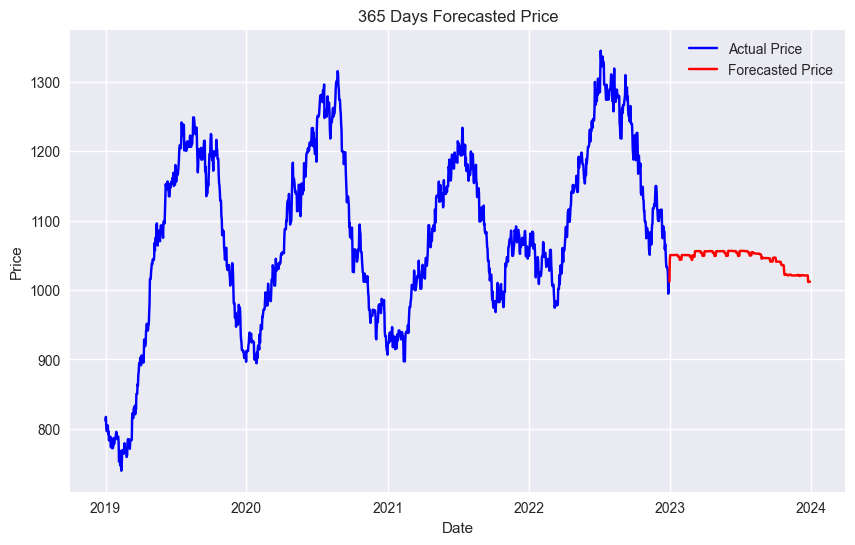

In [77]:
future_predictions = model.predict(future_df)
future_df["future_predictions"] = future_predictions


df_filtered = df_copy[df_copy.index >= "2019-01-01"]

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(df_filtered.index, df_filtered['Price'], label='Actual Price', color='blue')
plt.plot(future_df.index, future_df['future_predictions'], label='Forecasted Price', color='red')
plt.legend()
plt.title('365 Days Forecasted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [78]:
df

,Price,dayofweek,dayofyear,dayofmonth,month,quarter,year,weekofyear,lag_5,lag_15,lag_25,lag_35
Date,,,,,,,,,,,,
2012-12-31,300.000000,0,366,31,12,4,2012,1,0.000000,0.000000,0.000000,0.000000
2013-01-01,299.553248,1,1,1,1,1,2013,1,0.000000,0.000000,0.000000,0.000000
2013-01-02,302.043389,2,2,2,1,1,2013,1,0.000000,0.000000,0.000000,0.000000
2013-01-03,307.849084,3,3,3,1,1,2013,1,0.000000,0.000000,0.000000,0.000000
2013-01-04,307.091766,4,4,4,1,1,2013,1,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,1030.524458,0,360,26,12,4,2022,52,1057.390125,1115.661244,1101.750808,1120.258993
2022-12-27,1022.667013,1,361,27,12,4,2022,52,1041.444074,1083.613398,1099.449271,1123.664120
2022-12-28,994.676194,2,362,28,12,4,2022,52,1033.101338,1074.562481,1099.449271,1120.990001


In [79]:
def iterative_forecast(model, df, forecast_days=365, forecast_horizon=7):  # Added forecast_horizon
    """Performs iterative multi-step forecasting."""

    predictions = []

    historical_data = df[["Price"]]  # Important: Create a copy to avoid modifying the original
    future_dates = pd.date_range(start=historical_data.index[-1] + pd.Timedelta(days=1), periods=forecast_days)
    future_df = pd.DataFrame(index=future_dates)

    lags = [5, 15, 25, 35] # Example lags, adjust as needed

    for i in range(forecast_days // forecast_horizon):  # Iterate in chunks of forecast_horizon
        current_horizon = min(forecast_horizon, forecast_days - i * forecast_horizon) # Adjust for last, potentially shorter period
        
        # Create features for the current horizon
        current_future_df = pd.DataFrame(index=future_dates[i * forecast_horizon : i * forecast_horizon + current_horizon])
        current_future_df["dayofweek"] = current_future_df.index.day_of_week.astype(int)
        current_future_df["dayofyear"] = current_future_df.index.day_of_year.astype(int)
        current_future_df["dayofmonth"] = current_future_df.index.day
        current_future_df["month"] = current_future_df.index.month.astype(int)
        current_future_df["quarter"] = current_future_df.index.quarter.astype(int)
        current_future_df["year"] = current_future_df.index.year.astype(int)
        current_future_df["weekofyear"] = current_future_df.index.isocalendar().week
        for lag in lags:
            current_future_df[f'lag_{lag}'] = np.nan

        for j in range(current_horizon):
            for lag in lags:
                lag_index = i * forecast_horizon + j - lag
                if lag_index >= 0:
                    current_future_df.iloc[j, current_future_df.columns.get_loc(f'lag_{lag}')] = historical_data['Price'].iloc[lag_index]
                else:
                    current_future_df.iloc[j, current_future_df.columns.get_loc(f'lag_{lag}')] = np.nan # Handles negative index

        # Make predictions for the current horizon
        current_predictions = model.predict(current_future_df)
        predictions.extend(current_predictions)

        # Update historical data with the predictions (for the next iteration)
        predicted_prices = pd.Series(current_predictions, index=current_future_df.index)
        historical_data = pd.concat([historical_data, predicted_prices.to_frame(name='Price')])

    current_future_df['Price'] = predictions[:forecast_days] # Truncate predictions if necessary
    return current_future_df

current_future_df = iterative_forecast(model, df, forecast_days=365, forecast_horizon=7)
current_future_df

ValueError: Length of values (364) does not match length of index (7)